In [1]:
import pandas as pd
import re
import os

# --- File Paths ---
INPUT_RAW_TOXIC_DATA_PATH = "classification_and_explaination_toxic_conversation.csv"
OUTPUT_CLEANED_TOXIC_DATA_PATH = "cleaned_toxic_conversations_final.csv"

# --- 1. Load the Raw Toxic Dataset ---
print(f"[INFO] Loading raw toxic dataset from: '{INPUT_RAW_TOXIC_DATA_PATH}'")
try:
    # Attempt to read with UTF-8 encoding first.
    # If UnicodeDecodeError occurs, try 'latin1' and then manually clean characters.
    toxic_raw_df = pd.read_csv(INPUT_RAW_TOXIC_DATA_PATH, encoding='utf-8')
    print(f"[INFO] Successfully loaded {len(toxic_raw_df)} rows.")
except UnicodeDecodeError:
    print(f"[WARNING] UTF-8 decode error. Attempting with 'latin1' encoding and manual character cleanup.")
    toxic_raw_df = pd.read_csv(INPUT_RAW_TOXIC_DATA_PATH, encoding='latin1')
    
    # Function to clean common accented characters after reading with 'latin1'
    def fix_accented_chars(text_input):
        if isinstance(text_input, str):
            text_input = text_input.replace('Ã¨', 'è').replace('Ã¬', 'ì').replace('Ã ', 'à').replace('Ã²', 'ò').replace('Ã¹', 'ù')
            text_input = text_input.replace('â€œ', '"').replace('â€', '"').replace('â€™', "'") # Fix quotes and apostrophes
        return text_input
    
    # Apply cleanup to relevant text columns
    for col_name in ['conversation', 'explaination']:
        if col_name in toxic_raw_df.columns:
            toxic_raw_df[col_name] = toxic_raw_df[col_name].apply(fix_accented_chars)
    print("[INFO] Accented characters cleaned after 'latin1' read.")

# --- 2. Extract Most Toxic Sentence ---
print("[STEP 1] Extracting the most toxic sentence from explanations...")

def get_most_toxic_sentence(explanation_column_text):
    """
    Extracts the most toxic sentence using regex from the explanation text.
    """
    if isinstance(explanation_column_text, str):
        # Regex to find text within quotes after "La frase più tossica è: "
        match_obj = re.search(r'La frase più tossica è: "([^"]*)"', explanation_column_text)
        if match_obj:
            return match_obj.group(1).strip()
    return None

toxic_raw_df['most_toxic_sentence'] = toxic_raw_df['explaination'].apply(get_most_toxic_sentence)
print("[COMPLETED] Most toxic sentence extracted.")

# --- 3. Reformat Conversations ---
print("[STEP 2] Reformatting conversation dialogues...")

def format_dialogue(dialogue_text, speaker_one_name, speaker_two_name):
    """
    Reformats the raw conversation text into a consistent '"Name: Message"' format.
    """
    if not isinstance(dialogue_text, str):
        return None
    
    # Preliminary cleaning: remove numbering and excess spaces
    # Remove turn numbers like "1. ", "2. "
    clean_dialogue_text = re.sub(r'\d+\.\s*"', '', dialogue_text)
    # Ensure "Name:" format without extra space like "Name :"
    clean_dialogue_text = re.sub(r'(\w+):\s*', r'\1:', clean_dialogue_text)

    # Replace multiple spaces with a single space
    clean_dialogue_text = re.sub(r'\s{2,}', ' ', clean_dialogue_text)
    
    # Handle cases where the whole text is wrapped in quotes
    if clean_dialogue_text.startswith('"') and clean_dialogue_text.endswith('"'):
        clean_dialogue_text = clean_dialogue_text[1:-1]
        
    formatted_turns = []
    current_speaker_in_loop = None
    current_turn_dialogue = []
    
    # Identify all possible speaker variations for splitting (case-insensitive if needed, but title case is used for names)
    potential_speakers = [speaker_one_name, speaker_two_name, speaker_one_name.title(), speaker_two_name.title()]
    # Sort by length descending to prevent partial matches for shorter names
    potential_speakers = sorted(list(set(potential_speakers)), key=len, reverse=True)

    # Split the dialogue by identified speaker patterns (e.g., "Name:")
    # The regex captures the speaker pattern so it's included in the parts
    dialogue_parts = re.split(r'(' + '|'.join(re.escape(s + ':') for s in potential_speakers) + r')', clean_dialogue_text)
    
    for part_item in dialogue_parts:
        if not part_item.strip():
            continue
        
        # Check if the part is a speaker indicator (e.g., "Name:")
        if any(part_item.strip().startswith(s + ':') for s in potential_speakers):
            if current_speaker_in_loop and current_turn_dialogue:
                # Add the completed turn to formatted_turns
                formatted_turns.append(f'"{current_speaker_in_loop}: {" ".join(current_turn_dialogue).strip()}"')
            
            # Set the new speaker and reset dialogue for the new turn
            current_speaker_in_loop = part_item.strip()[:-1].strip() # Remove the trailing colon
            current_turn_dialogue = []
        else:
            # This part is dialogue from the current speaker
            current_turn_dialogue.append(part_item.strip())
            
    # Add the last collected turn if any
    if current_speaker_in_loop and current_turn_dialogue:
        formatted_turns.append(f'"{current_speaker_in_loop}: {" ".join(current_turn_dialogue).strip()}"')

    return ' '.join(formatted_turns)


# Apply the dialogue reformatting function to the DataFrame
toxic_raw_df['conversation_reformatted'] = toxic_raw_df.apply(
    lambda row: format_dialogue(row['conversation'], row['name1'], row['name2']), axis=1
)

# Drop rows where conversation reformatting failed or resulted in empty strings
toxic_processed_df = toxic_raw_df.dropna(subset=['conversation_reformatted'])
toxic_processed_df = toxic_processed_df[toxic_processed_df['conversation_reformatted'].str.strip() != '']

print("[COMPLETED] Conversations reformatted.")

# --- 4. Clean Explanations and Arrange Final Columns ---
print("[STEP 3] Cleaning explanations and arranging final columns...")

def remove_toxic_sentence_from_explanation(explanation_full_text):
    """
    Cleans the explanation text by removing the specific "most toxic sentence" part.
    """
    if isinstance(explanation_full_text, str):
        # Remove the pattern "La frase più tossica è: "..." and multiple spaces
        cleaned_explanation = re.sub(r'La frase più tossica è: ".*?"', '', explanation_full_text)
        cleaned_explanation = re.sub(r'\s{2,}', ' ', cleaned_explanation).strip()
        return cleaned_explanation
    return None

toxic_processed_df['explanation_cleaned'] = toxic_processed_df['explaination'].apply(remove_toxic_sentence_from_explanation)

# Assign a conversation type. 'person_couple' seems to describe the type for toxic data.
toxic_processed_df['conversation_category'] = toxic_processed_df['person_couple']

# Add the 'toxic_label' column (all are 1 for this dataset as confirmed by user)
toxic_processed_df['toxic_label'] = 1 

# Standardize name casing (e.g., Title Case)
toxic_processed_df['name1'] = toxic_processed_df['name1'].str.title()
toxic_processed_df['name2'] = toxic_processed_df['name2'].str.title()

# Select and rename final columns for consistency
final_columns_for_toxic_df = toxic_processed_df[[
    'conversation_category',
    'name1',
    'name2',
    'conversation_reformatted', # This is the cleaned dialogue
    'most_toxic_sentence',
    'explanation_cleaned',
    'toxic_label'
]].rename(columns={'conversation_reformatted': 'conversation'})

print("[COMPLETED] Final columns arranged and cleaned.")

# --- 5. Save the Cleaned Toxic Dataset ---
print(f"\n[INFO] Saving the cleaned toxic dataset to: '{OUTPUT_CLEANED_TOXIC_DATA_PATH}'")
final_columns_for_toxic_df.to_csv(OUTPUT_CLEANED_TOXIC_DATA_PATH, index=False, encoding='utf-8')
print("[COMPLETED] Cleaned toxic dataset saved successfully.")
print(f"[OUTPUT] File saved at: '{OUTPUT_CLEANED_TOXIC_DATA_PATH}'")
print(f"[ROWS] Total rows in the cleaned toxic dataset: {len(final_columns_for_toxic_df)}")

# Display the first few rows of the cleaned dataset for verification
print("\nFirst 5 rows of the cleaned toxic dataset:")
print(final_columns_for_toxic_df.head())

[INFO] Loading raw toxic dataset from: 'classification_and_explaination_toxic_conversation.csv'
[INFO] Successfully loaded 1000 rows.
[STEP 1] Extracting the most toxic sentence from explanations...
[COMPLETED] Most toxic sentence extracted.
[STEP 2] Reformatting conversation dialogues...
[COMPLETED] Conversations reformatted.
[STEP 3] Cleaning explanations and arranging final columns...
[COMPLETED] Final columns arranged and cleaned.

[INFO] Saving the cleaned toxic dataset to: 'cleaned_toxic_conversations_final.csv'
[COMPLETED] Cleaned toxic dataset saved successfully.
[OUTPUT] File saved at: 'cleaned_toxic_conversations_final.csv'
[ROWS] Total rows in the cleaned toxic dataset: 803

First 5 rows of the cleaned toxic dataset:
               conversation_category      name1    name2  \
2         Persona violenta e Succube    Lucindo   Ubaldo   
5  Manipolatore e Dipendente emotiva  Nicoletto  Armenio   
6        Sadico-Crudele e Masochista    Aderita  Rogelio   
8  Manipolatore e Dipe

In [2]:
import pandas as pd
import re
import os

# --- File Paths ---
INPUT_HEALTHY_DATA_PATH = "healthy_dataset_complete.csv"
INPUT_CLEANED_TOXIC_DATA_PATH = "cleaned_toxic_conversations_final.csv"
OUTPUT_UNIFIED_DATA_PATH = "unified_conversation_dataset.csv"

# --- Common Function for Character Fixes (from previous code) ---
def fix_accented_chars(text_input):
    """
    Fixes common accented characters and smart quotes after reading with 'latin1' encoding.
    """
    if isinstance(text_input, str):
        text_input = text_input.replace('Ã¨', 'è').replace('Ã¬', 'ì').replace('Ã ', 'à').replace('Ã²', 'ò').replace('Ã¹', 'ù')
        text_input = text_input.replace('â€œ', '"').replace('â€', '"').replace('â€™', "'") # Fix quotes and apostrophes
    return text_input

# --- 1. Load and Process Healthy Dataset ---
print(f"[INFO] Loading healthy dataset from: '{INPUT_HEALTHY_DATA_PATH}'")
try:
    healthy_df = pd.read_csv(INPUT_HEALTHY_DATA_PATH, encoding='utf-8')
    print(f"[INFO] Successfully loaded {len(healthy_df)} rows.")
except UnicodeDecodeError:
    print(f"[WARNING] UTF-8 decode error for healthy dataset. Attempting with 'latin1' encoding and manual character cleanup.")
    healthy_df = pd.read_csv(INPUT_HEALTHY_DATA_PATH, encoding='latin1')
    
    # Apply cleanup to conversation column
    if 'conversation' in healthy_df.columns:
        healthy_df['conversation'] = healthy_df['conversation'].apply(fix_accented_chars)
    print("[INFO] Accented characters in healthy dataset cleaned after 'latin1' read.")

# --- 2. Clean and Standardize Healthy Dataset ---
print("[STEP 1] Cleaning and standardizing healthy dataset...")

# Handle incomplete rows: Drop rows where critical columns are missing or empty after initial load
# Based on the format, 'conversation' is the most critical text field.
initial_rows = len(healthy_df)
healthy_df.dropna(subset=['conversation', 'name1', 'name2'], inplace=True)
healthy_df = healthy_df[healthy_df['conversation'].str.strip() != '']
healthy_df = healthy_df[healthy_df['name1'].str.strip() != '']
healthy_df = healthy_df[healthy_df['name2'].str.strip() != '']

rows_after_cleanup = len(healthy_df)
if initial_rows > rows_after_cleanup:
    print(f"[INFO] Removed {initial_rows - rows_after_cleanup} incomplete or malformed rows from healthy dataset.")

# Add 'toxic_label' column (0 for non-toxic)
healthy_df['toxic_label'] = 0

# Standardize name casing
healthy_df['name1'] = healthy_df['name1'].str.title()
healthy_df['name2'] = healthy_df['name2'].str.title()

# Rename 'conversation_type' to 'conversation_category' for consistency with toxic dataset
# if 'conversation_type' exists and 'conversation_category' does not.
if 'conversation_type' in healthy_df.columns and 'conversation_category' not in healthy_df.columns:
    healthy_df.rename(columns={'conversation_type': 'conversation_category'}, inplace=True)

# Add dummy columns for 'most_toxic_sentence' and 'explanation_cleaned'
# as these are specific to toxic conversations. Fill with empty string or None.
# This ensures column compatibility for merging.
healthy_df['most_toxic_sentence'] = '' # No toxic sentence for healthy conversations
healthy_df['explanation_cleaned'] = '' # No explanation of toxicity for healthy conversations

# Define the final desired columns and their order for both datasets before merging
# This ensures both DataFrames have the exact same columns for concatenation
FINAL_COMMON_COLUMNS = [
    'conversation_category',
    'name1',
    'name2',
    'conversation',
    'most_toxic_sentence',
    'explanation_cleaned',
    'toxic_label'
]

# Select and reorder columns for the healthy dataset
healthy_df_cleaned = healthy_df[FINAL_COMMON_COLUMNS]
print("[COMPLETED] Healthy dataset standardized.")

# --- 3. Load Cleaned Toxic Dataset ---
print(f"\n[INFO] Loading cleaned toxic dataset from: '{INPUT_CLEANED_TOXIC_DATA_PATH}'")
if not os.path.exists(INPUT_CLEANED_TOXIC_DATA_PATH):
    print(f"[ERROR] Cleaned toxic dataset not found at '{INPUT_CLEANED_TOXIC_DATA_PATH}'. Please ensure previous script was run successfully.")
    exit() # Exit if the toxic dataset isn't available

toxic_cleaned_df = pd.read_csv(INPUT_CLEANED_TOXIC_DATA_PATH, encoding='utf-8')
# Ensure toxic_cleaned_df also has the exact same columns and order
toxic_cleaned_df = toxic_cleaned_df[FINAL_COMMON_COLUMNS]
print(f"[INFO] Successfully loaded {len(toxic_cleaned_df)} rows.")

# --- 4. Merge the Two Datasets ---
print("\n[STEP 2] Merging healthy and toxic datasets...")

unified_df = pd.concat([healthy_df_cleaned, toxic_cleaned_df], ignore_index=True)

print("[COMPLETED] Datasets merged.")
print(f"[INFO] Total rows in unified dataset: {len(unified_df)}")

# --- 5. Save the Unified Dataset ---
print(f"\n[INFO] Saving unified dataset to: '{OUTPUT_UNIFIED_DATA_PATH}'")
unified_df.to_csv(OUTPUT_UNIFIED_DATA_PATH, index=False, encoding='utf-8')
print("[COMPLETED] Unified dataset saved successfully.")
print(f"[OUTPUT] File saved at: '{OUTPUT_UNIFIED_DATA_PATH}'")

# Display the first few rows of the unified dataset for verification
print("\nFirst 5 rows of the unified dataset:")
print(unified_df.head())

# Display the last 5 rows to see examples from the toxic part
print("\nLast 5 rows of the unified dataset (likely toxic examples):")
print(unified_df.tail())

# Quick check on label distribution
print("\nDistribution of 'toxic_label' in unified dataset:")
print(unified_df['toxic_label'].value_counts())

[INFO] Loading healthy dataset from: 'healthy_dataset_complete.csv'
[INFO] Successfully loaded 1005 rows.
[STEP 1] Cleaning and standardizing healthy dataset...
[COMPLETED] Healthy dataset standardized.

[INFO] Loading cleaned toxic dataset from: 'cleaned_toxic_conversations_final.csv'
[INFO] Successfully loaded 803 rows.

[STEP 2] Merging healthy and toxic datasets...
[COMPLETED] Datasets merged.
[INFO] Total rows in unified dataset: 1808

[INFO] Saving unified dataset to: 'unified_conversation_dataset.csv'
[COMPLETED] Unified dataset saved successfully.
[OUTPUT] File saved at: 'unified_conversation_dataset.csv'

First 5 rows of the unified dataset:
                  conversation_category    name1    name2  \
0             Risoluzione dei Conflitti   Matteo    Viola   
1       Condivisione di Hobby/Interessi  Aurelio  Ginevra   
2          Pianificazione Eventi Futuri   Matteo   Chiara   
3  Vulnerabilità Emotiva e Accettazione   Matteo   Giulia   
4                    Supporto Recipr

Required libraries imported successfully.
Unified dataset loaded successfully from 'unified_conversation_dataset.csv'.
Total rows in unified dataset: 1808
Columns: ['conversation_category', 'name1', 'name2', 'conversation', 'most_toxic_sentence', 'explanation_cleaned', 'toxic_label']

--- Basic DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   conversation_category  1808 non-null   object
 1   name1                  1808 non-null   object
 2   name2                  1808 non-null   object
 3   conversation           1808 non-null   object
 4   most_toxic_sentence    620 non-null    object
 5   explanation_cleaned    803 non-null    object
 6   toxic_label            1808 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 99.0+ KB

--- First 5 Rows of the Unified Dataset ---
                 

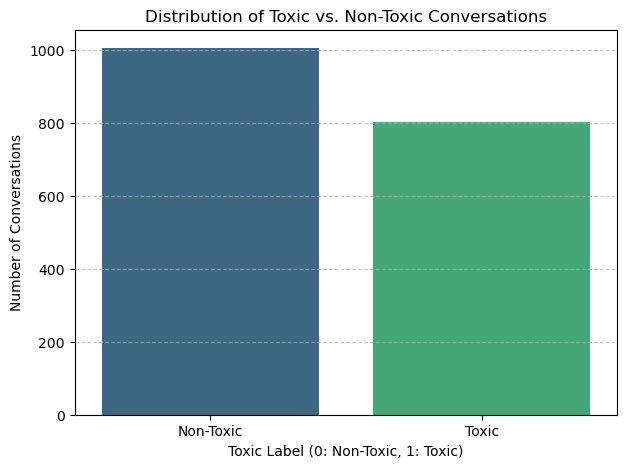


--- Conversation Length Analysis ---
Overall Conversation Length Statistics (in words):
count    1808.000000
mean      143.531527
std        54.633498
min        23.000000
25%       110.000000
50%       128.000000
75%       156.000000
max       312.000000
Name: conversation_length, dtype: float64

Conversation Length Statistics by Toxic Label:
              count        mean        std   min    25%    50%    75%    max
toxic_label                                                                 
0            1005.0  127.055721  22.910463  72.0  112.0  125.0  140.0  232.0
1             803.0  164.151930  72.815942  23.0  105.0  137.0  238.5  312.0


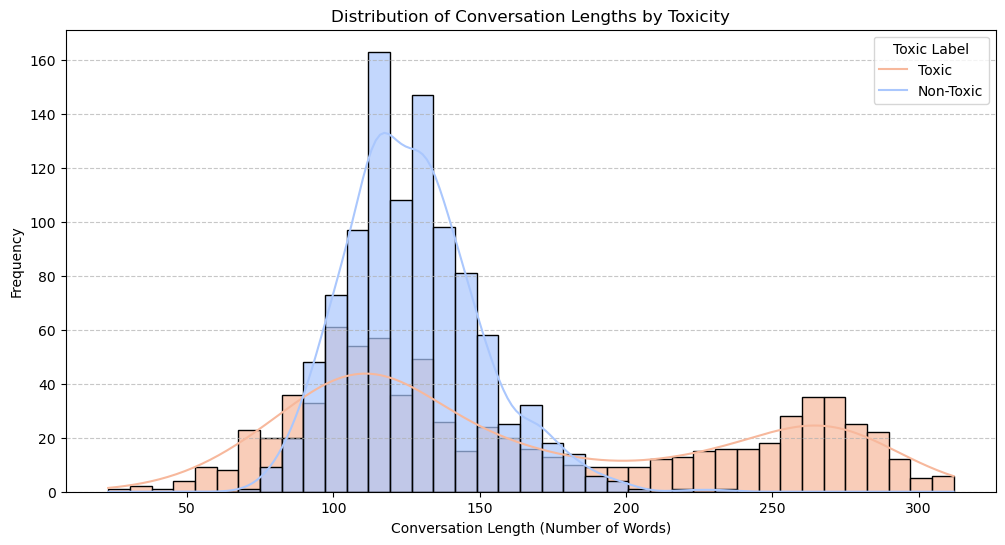

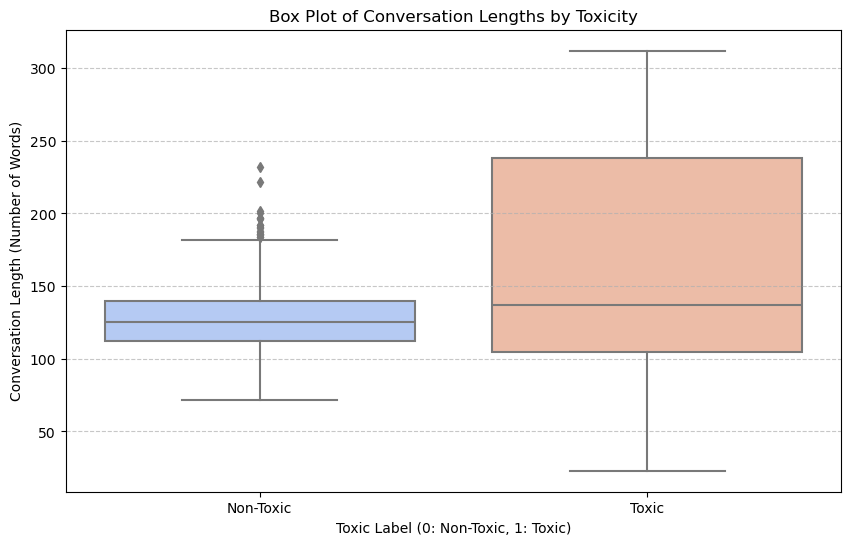


EDA completed. Insights into dataset structure, label distribution, and conversation lengths gained.


In [3]:
# --- Cell 1: Import Libraries ---
# Import necessary libraries for data manipulation and visualization.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')

print("Required libraries imported successfully.")

# --- Cell 2: Load the Unified Dataset ---
# Load the preprocessed and unified dataset into a Pandas DataFrame.

# Define the path to your unified dataset file
UNIFIED_DATASET_PATH = "unified_conversation_dataset.csv"

try:
    unified_df = pd.read_csv(UNIFIED_DATASET_PATH, encoding='utf-8')
    print(f"Unified dataset loaded successfully from '{UNIFIED_DATASET_PATH}'.")
    print(f"Total rows in unified dataset: {len(unified_df)}")
    print(f"Columns: {unified_df.columns.tolist()}")
except FileNotFoundError:
    print(f"Error: The file '{UNIFIED_DATASET_PATH}' was not found. Please ensure it's in the correct directory.")
    # Exit or handle the error as appropriate for your notebook environment
    # For a notebook, you might just display an error message and stop execution
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")


# --- Cell 3: Display Basic Information and First Rows ---
# Check the DataFrame's structure, data types, and preview the first few entries.

print("\n--- Basic DataFrame Information ---")
unified_df.info()

print("\n--- First 5 Rows of the Unified Dataset ---")
print(unified_df.head())

print("\n--- Last 5 Rows of the Unified Dataset ---")
print(unified_df.tail()) # Useful to see if toxic examples are present at the end


# --- Cell 4: Analyze 'toxic_label' Distribution ---
# Visualize the distribution of toxic (1) vs. non-toxic (0) conversations.

print("\n--- Distribution of 'toxic_label' ---")
label_counts = unified_df['toxic_label'].value_counts()
print(label_counts)

plt.figure(figsize=(7, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Toxic vs. Non-Toxic Conversations')
plt.xlabel('Toxic Label (0: Non-Toxic, 1: Toxic)')
plt.ylabel('Number of Conversations')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- Cell 5: Analyze Conversation Lengths ---
# Calculate and visualize the length (in words) of conversations for both categories.

print("\n--- Conversation Length Analysis ---")

# Calculate conversation length in words
unified_df['conversation_length'] = unified_df['conversation'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Display basic statistics for conversation lengths
print("Overall Conversation Length Statistics (in words):")
print(unified_df['conversation_length'].describe())

# Statistics by toxic_label
print("\nConversation Length Statistics by Toxic Label:")
print(unified_df.groupby('toxic_label')['conversation_length'].describe())

# Visualize conversation lengths
plt.figure(figsize=(12, 6))
sns.histplot(data=unified_df, x='conversation_length', hue='toxic_label', kde=True, palette='coolwarm', alpha=0.7)
plt.title('Distribution of Conversation Lengths by Toxicity')
plt.xlabel('Conversation Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend(title='Toxic Label', labels=['Toxic', 'Non-Toxic'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize conversation lengths using box plots for clearer comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=unified_df, x='toxic_label', y='conversation_length', palette='coolwarm')
plt.title('Box Plot of Conversation Lengths by Toxicity')
plt.xlabel('Toxic Label (0: Non-Toxic, 1: Toxic)')
plt.ylabel('Conversation Length (Number of Words)')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nEDA completed. Insights into dataset structure, label distribution, and conversation lengths gained.")